In [6]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LogNorm
import plotly.graph_objects as go


In [48]:
info = np.loadtxt('E_field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]

# Load the csv file
df = pd.read_csv('E_field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E

E = np.sqrt(Er**2 + Ez**2)


# initial conditions - not needed for interpolation
R = np.loadtxt('E_field/r.txt')*convert_dist
Z = np.loadtxt('E_field/z.txt')*convert_dist


r_min= 0.0
r_max= 0.00030000000000000003
z_min= -0.00015000000000000001
z_max= 0.0007000000000000001


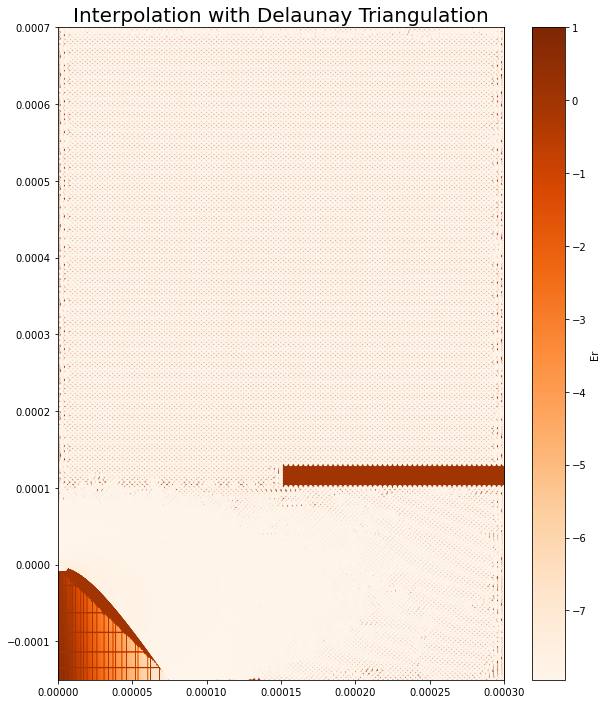

In [9]:
# Sort the data by (r, z) and get unique points with their corresponding Er values
data = sorted(zip(r, z, Er))
points, Er_values = np.array([(x[0], x[1]) for x in data]), np.array([x[2] for x in data])

# Create a grid for interpolation
r_min, r_max, nr = r.min(), r.max(), 500  # Adjust grid size as needed
z_min, z_max, nz = z.min(), z.max(), 500  # Adjust grid size as needed
r_lin = np.linspace(r_min, r_max, nr)
z_lin = np.linspace(z_min, z_max, nz)
rv, zv = np.meshgrid(r_lin, z_lin)

# Flatten and stack the grid points
pp = np.vstack((rv.flatten(), zv.flatten())).T

# Compute Delaunay triangulation of the data points
tri = Delaunay(points)

# Find the simplices containing each point in the grid
ss = tri.find_simplex(pp)

# For each point in the grid, compute its barycentric coordinates within
# its simplex, and use them to interpolate the function value
out = np.zeros_like(rv)
ndim = tri.transform.shape[2]
for i in np.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(p) - tri.transform[i, ndim].reshape(-1,1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)] 
    # Here we need to use the indices of the points in the simplices, not the coordinates
    sp_indices = tri.simplices[i]
    # scale and shift the p coordinates to get indices
    ix = ((p[:, 0] - r_min) / (r_max - r_min) * (nr - 1)).astype(int)
    iy = ((p[:, 1] - z_min) / (z_max - z_min) * (nz - 1)).astype(int)
    if len(αβγ) > 0:
        out[ix, iy] = αβγ @ Er_values[sp_indices]
out = out / out.max()  # normalize for color scale

# Plot the interpolated function
plt.figure(figsize=(10,12))
plt.imshow(out.T, origin='lower', extent=[r_min, r_max, z_min, z_max], aspect='auto', cmap='Oranges')
plt.colorbar(label='Er')
plt.scatter(points[:, 0], points[:, 1], c=Er_values, s=10, cmap='Oranges')
plt.title('Interpolation with Delaunay Triangulation', size=20)
plt.show()


In [3]:
points = np.column_stack((r, z))
tri = Delaunay(points)

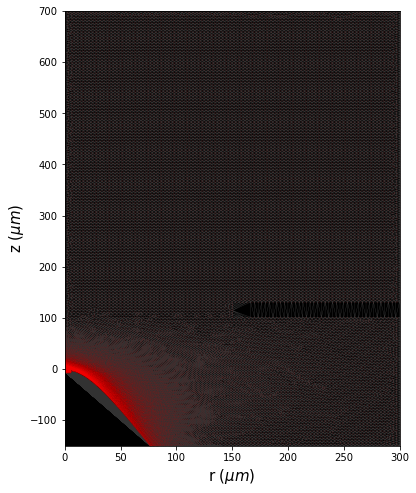

In [24]:
fig = plt.figure(figsize=(6,8), facecolor='white')
ax = fig.add_subplot(111, facecolor='black')
ax.triplot(points[:,0]*1e6, points[:,1]*1e6, tri.simplices, color='white', linewidth=0.4,alpha=0.2)
ax.scatter(points[:,0]*1e6, points[:,1]*1e6, color='r',marker='.', s=0.5, alpha=0.1)
ax.set_xlabel('r ($\mu m$)', size=15, color='black')
ax.set_ylabel('z ($\mu m$)', size=15, color='black')
ax.set_xlim([r.min()*1e6, r.max()*1e6])
ax.set_ylim([z.min()*1e6, z.max()*1e6])
plt.show()

In [39]:

request=np.array([100e-6,0])


In [42]:
interp=LinearNDInterpolator(tri, np.vstack((Er.flatten(), Ez.flatten())).T, fill_value=np.nan, rescale=False)

In [43]:
interp(request)

array([[3074143.0021039 , 7574129.58052451]])